In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import scipy.signal as signal
import scipy.fftpack as fftpack
import random
import time
import sys
sys.path.append("../..")
from mfilter.regressions import *
from mfilter.types import FrequencySamples, TimeSeries, FrequencySeries, TimesSamples
from mfilter.filter import *
from microlensing.lib.microlensing import *
from heapq import heappush, heappop 

%matplotlib inline
plt.style.use('seaborn')
days_to_sec = 1 * 24 * 60 * 60
sec_to_days = 1 /(60 * 60 * 24)

In [2]:
files = glob.glob("MLensing/*.mjd")
print(len(files))

# creating templates
def mlens_temp(times, pars, idx=0, t0=None):
    if t0 is None:
        t0 = np.random.random() * times.duration*0.8 + times.min() + times.duration * 0.1
    ml = microlens(tE=pars['tE'][idx], U0=pars['U0'][idx], fs=pars['fs'][idx], t0=t0*sec_to_days)
    temp = ml.eval(times * sec_to_days)
    return TimeSeries(temp, times=TimesSamples(times)), t0


# generate parameter generator object and sample parameters
parfile = "test.txt" # here put your favourite file with columns tE, U0 and fs, in data directory
pargen = microlens_pars(parsfile = "../../microlensing/data/%s" % parfile)
nsample = 100
pars = pargen.sample(nsample)

1165


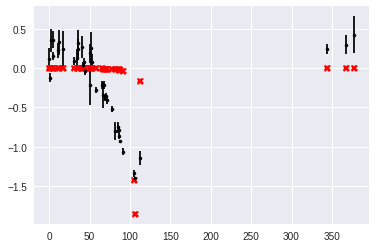

In [60]:
j = np.random.randint(0, len(files)-1)

def get_data(j, ini=0, fin=100):
    a = pd.read_csv(files[j], skiprows=3, header=None, sep=" ")
    a.columns = ["MJD", "Mag", "err"]
    times = TimesSamples(a["MJD"][ini:fin])
    times -= times.min()
    times *= days_to_sec
    data = TimeSeries(a["Mag"][ini:fin], times=times)
    data -= np.median(data)
    return data, times, a["err"].tolist()[ini:fin]

data, times, err = get_data(394, ini=100, fin=140)
plt.errorbar(times*sec_to_days, data, yerr=err, fmt=".", color="k")
temp0, _ = mlens_temp(times, pars, idx=20, t0=times[np.argmin(data)])
plt.plot(times*sec_to_days, temp0, 'rX')

In [4]:
# errors = np.array(a["err"].tolist()[60:])
# errors = np.append(errors, -np.array(a["err"].tolist()[60:]))
# plt.hist(errors)
# print(np.std(errors))

nyquist shannon says, maximum frequency is 2.4567046476595203e-06
3.0708808095744004e-08
0.9436562549246622
0.7302913799441704


/home/pancho/.local/lib/python3.5/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


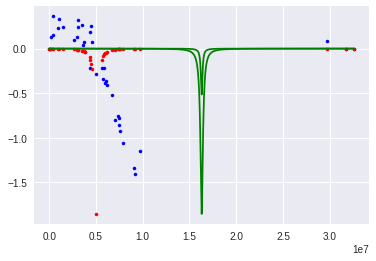

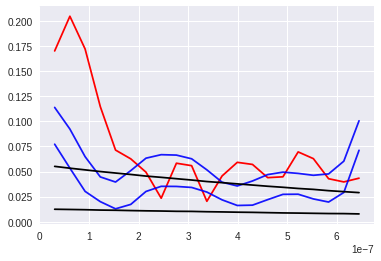

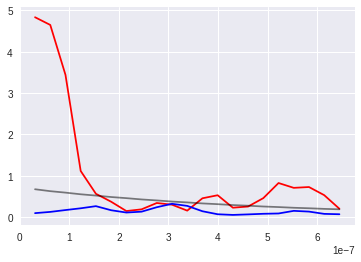

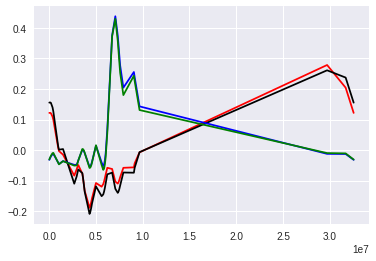

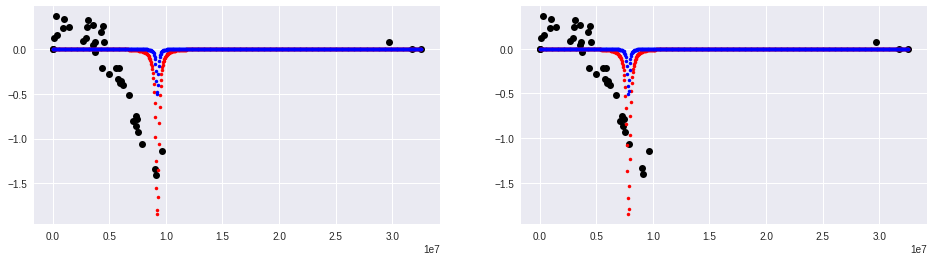

In [74]:
# data = TimeSeries(temp0 + np.random.normal(0, np.std(err), len(data)), times=times)
# data = TimeSeries(a["err"].tolist()[60:], times=times)
temp, _ = mlens_temp(times, pars, idx=20, t0=times[20])
temp2, _ = mlens_temp(times, pars, idx=23, t0=times[20])
avg_dt = times.duration / len(times)

time_test = TimesSamples(np.linspace(0, times.duration, len(times)*20))
temp_test, _ = mlens_temp(time_test, pars, idx=20, t0=time_test[int(len(time_test)/2)])
temp_test2, _ = mlens_temp(time_test, pars, idx=23, t0=time_test[int(len(time_test)/2)])
plt.plot(times, data, 'b.')
plt.plot(times, temp, 'r.')
plt.plot(time_test, temp_test, 'g')
plt.plot(time_test, temp_test2, 'g')

fs = len(times) / times.duration
print("nyquist shannon says, maximum frequency is", (2 * fs))
nyq = (fs / 2) * 1
samples_per_peak = 1
df = 1 / times.duration / samples_per_peak
print(df)
freqs = FrequencySamples(input_time=times,
                        minimum_frequency=samples_per_peak * df,
                        maximum_frequency=nyq + samples_per_peak * df,
                        samples_per_peak=samples_per_peak)
F = Dictionary(times, freqs)
reg = SGDRegression(alpha=10**(-10), max_iter=3000, tol=0.0001, phi=F)

F_test = Dictionary(time_test, freqs)
reg_test = SGDRegression(alpha=10**(-10), max_iter=3000, tol=0.0001, phi=F_test)
stilde = data.to_frequencyseries(reg=reg)
print(reg.score(data))
htilde = temp.to_frequencyseries(reg=reg)
htilde2 = temp2.to_frequencyseries(reg=reg)
htilde_test = temp_test.to_frequencyseries(reg=reg_test)
print(reg_test.score(temp_test))
htilde_test2 = temp_test2.to_frequencyseries(reg=reg_test)
plt.figure()
plt.plot(freqs, abs(stilde), 'r')
plt.plot(freqs, abs(htilde), 'b', alpha=0.9)
plt.plot(freqs, abs(htilde2), 'b', alpha=0.9)
plt.plot(freqs, abs(htilde_test), 'k')
plt.plot(freqs, abs(htilde_test2), 'k')

plt.figure()
plt.plot(freqs, freqs.lomb_scargle(times, data), 'r')
plt.plot(freqs, freqs.lomb_scargle(times, temp), 'b')
plt.plot(freqs, freqs.lomb_scargle(time_test, temp_test), 'k', alpha=0.5)

seg_n = len(data)//8
psd = freqs.lomb_welch(times, data, seg_n, 0.5)
# psd = None
snr = matched_filter(htilde, stilde, psd=psd, method="regression", reg=reg, 
                         times=times, unitary_energy=True)
snr2 = matched_filter(htilde2, stilde, psd=psd, method="regression", reg=reg, 
                         times=times, unitary_energy=True)
snr_test = matched_filter(htilde_test, stilde, psd=psd, method="regression", reg=reg, 
                         times=times, unitary_energy=True)
snr_test2 = matched_filter(htilde_test2, stilde, psd=psd, method="regression", reg=reg, 
                         times=times, unitary_energy=True)

plt.figure()
plt.plot(times, snr, 'r')
plt.plot(times, snr2, 'k')
plt.plot(times, snr_test, 'b')
plt.plot(times, snr_test2, 'g')



fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16,4))
ax1.plot(times, data, 'ko')
temp_test_t, _ = mlens_temp(time_test, pars, idx=20, 
                            t0=time_test[int(len(time_test)/2)] - times[np.argmax(snr_test)])
temp_test2_t, _ = mlens_temp(time_test, pars, idx=23, 
                            t0=time_test[int(len(time_test)/2)] - times[np.argmax(snr_test2)])
ax1.plot(time_test, temp_test_t, 'r.')
ax1.plot(time_test, temp_test2_t, 'b.')

ax2.plot(times, data, 'ko')
temp_t, _ = mlens_temp(time_test, pars, idx=20, t0=(times[20]- times[np.argmax(snr)])%times.duration)
temp2_t, _ = mlens_temp(time_test, pars, idx=23, t0=(times[20]- times[np.argmax(snr)])%times.duration)
ax2.plot(time_test, temp_t, 'r.')
ax2.plot(time_test, temp2_t, 'b.')

In [6]:
# create regresssors
# fs = len(times) / times.duration
# nyq = (fs / 2) * 3
# samples_per_peak = 5
# df = 1 / times.duration / samples_per_peak
# freqs = FrequencySamples(input_time=times,
#                         minimum_frequency=samples_per_peak * df,
#                         maximum_frequency=nyq + samples_per_peak * df,
#                         samples_per_peak=samples_per_peak)
# F = Dictionary(times, freqs)
# # reg = RidgeRegression(alpha=10**(0), phi=F)
# # reg = LassoRegression(alpha=10**(-3), phi=F)
# reg = SGDRegression(alpha=10**(-4), max_iter=200, phi=F)
# # score = -1
# # alpha = 10**(-6)
# # i = 0
# # while True:
# #     reg = SGDRegression(alpha=alpha, max_iter=200, phi=F)
# #     stilde = data.to_frequencyseries(reg=reg)
# #     score = reg.score(data)
# #     print("iteration {}, alpha {}, score is {}".format(i, round(alpha, 3), round(score, 3)), end="\r")
# #     if score > 0.5:
# #         break
# #     alpha += 0.005
# #     i += 1

# # 'LANDWEBER', 'STEEPEST_DESCENT', 'CGNR', 'CGNE', 'NORMS_FOR_LANDWEBER'
# stilde1 = data.to_frequencyseries(method="nfft", flags='STEEPEST_DESCENT')
# stilde2 = data.to_frequencyseries(method="nfft", flags='LANDWEBER')
# stilde3 = data.to_frequencyseries(method="nfft", flags='CGNR')
# stilde4 = data.to_frequencyseries(method="nfft", flags='CGNE')
# stilde5 = data.to_frequencyseries(method="nfft", flags='NORMS_FOR_LANDWEBER')
# print(len(freqs), len(times))

# seg_n = len(data)//10
# print(seg_n)
# psd = freqs.lomb_welch(times, data, seg_n, 0.5)
# psd_direct = freqs.lomb_scargle(times, data, norm="psd") 
# psd_error = freqs.lomb_scargle(times, errors, norm="psd")

# plt.figure()
# plt.plot(freqs, psd, 'r')
# plt.plot(freqs, psd_direct, 'b', alpha=0.5)
# # plt.plot(freqs, psd_error, "g")
# # plt.ylim([0, 1])

# plt.figure()
# plt.plot(stilde1.frequencies, abs(stilde1), label="STEEPEST_DESCENT")
# plt.plot(stilde2.frequencies, abs(stilde2), label="LANDWEBER")
# plt.plot(stilde3.frequencies, abs(stilde3), label="CGNR")
# plt.plot(stilde4.frequencies, abs(stilde4), label="CGNE")
# plt.plot(stilde5.frequencies, abs(stilde5), label="NORMS")
# plt.xlim(0, 0.04)
# plt.legend()

# psd = stilde1.frequency_object.lomb_welch(times, data, seg_n, 0.5)

../../microlensing/lib/microlensing.py:24: RuntimeWarning: divide by zero encountered in true_divide
  u = np.sqrt(self.U0**2 + ((times - self.t0)  /self.tE )**2)
../../microlensing/lib/microlensing.py:25: RuntimeWarning: invalid value encountered in true_divide
  A = (u**2 + 2.) / (u * np.sqrt(u**2 + 3))


Text(0,0.5,'$\\Delta$ mag')

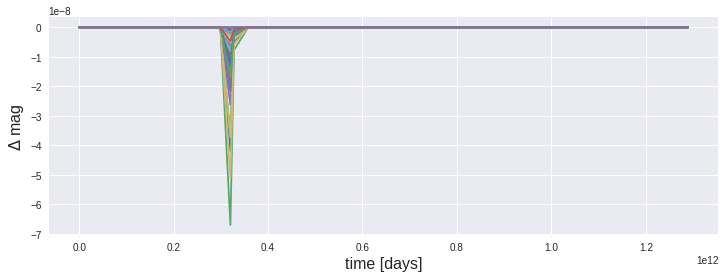

In [7]:
# define templates

fig, ax = plt.subplots(figsize = (12, 4))
templates = []
t0 = times.min() + times.duration/4
days_to_sec = 1 * 24 * 60 * 60
# loop among physical parameters, create microlens events and sample light curve
for tE, U0, fs in zip(pars['tE'], pars['U0'], pars['fs']):
    ml = microlens(tE = tE, U0 = U0, fs = fs, t0 = t0)
    temp = ml.eval(times)
#     if any(np.isnan(x) for x in temp):
#         continue
#     else:
    templates.append(TimeSeries(temp, times=times))
    ax.plot(times*days_to_sec, temp)
    
# ax.set_ylim(ax.get_ylim()[::-1])
# ax.set_xlim(50200, 50300)
ax.set_xlabel("time [days]", fontsize = 16)
ax.set_ylabel("$\Delta$ mag", fontsize = 16)

# reg = SGDRegression(alpha=10**(-10), max_iter=200, phi=F)

# htildes = []
# for temp in templates:
#     htildes.append(temp.to_frequencyseries(reg=reg))
    

0.9387677217031516


../../microlensing/lib/microlensing.py:24: RuntimeWarning: divide by zero encountered in true_divide
  u = np.sqrt(self.U0**2 + ((times - self.t0)  /self.tE )**2)
../../microlensing/lib/microlensing.py:25: RuntimeWarning: invalid value encountered in true_divide
  A = (u**2 + 2.) / (u * np.sqrt(u**2 + 3))
/home/pancho/.local/lib/python3.5/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


../../mfilter/filter/matchedfilter.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  norm = 1 / np.sqrt(h_norm)
../../mfilter/types/arrays.py:85: RuntimeWarning: invalid value encountered in multiply
  return self._data * other


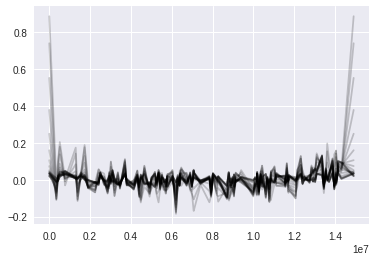

In [15]:
def match_all(stilde, templates, times, method="regression", reg=None, psd=None, threshold=0.64, tol=0.1):
    
    candidates = {}
    maximums = {}
    times_match = {}
    for i in range(len(templates)):
        if any(np.isnan(x) for x in templates[i]):
            print("has nan", end="\r")
            continue
        else:
            print("{} templates compared of {}".format(i, len(templates)), end="\r")
            htilde = templates[i].to_frequencyseries(method=method, reg=reg)
            snr = matched_filter(htilde, stilde, psd=psd, reg=reg, method=method, times=times, unitary_energy=False)
            if max(abs(snr)) > threshold:
                candidates[i] = snr
                maximums[i] = max(abs(snr))
                times_match[i] = times[np.argmax(abs(snr))]
            
        plt.plot(times, snr, 'k', alpha=0.2)
    return candidates, maximums, times_match

data, times, err = get_data(393)
F = Dictionary(times, freqs)
reg = SGDRegression(alpha=10**(-4), max_iter=200, phi=F)
stilde = data.to_frequencyseries(reg=reg)
print(reg.score(data))

templates = []
t0 = times.min() + times.duration/2
# loop among physical parameters, create microlens events and sample light curve
for tE, U0, fs in zip(pars['tE'], pars['U0'], pars['fs']):
    ml = microlens(tE = tE, U0 = U0, fs = fs, t0 = t0)
    temp = ml.eval(times)
#     if any(np.isnan(x) for x in temp):
#         continue
#     else:
    templates.append(TimeSeries(temp, times=times))
    
seg_n = len(data)//8
psd = freqs.lomb_welch(times, data, seg_n, 0.5)

candidates, maximums, times_match = match_all(stilde, templates, times, method="regression", reg=reg, psd=psd)
        

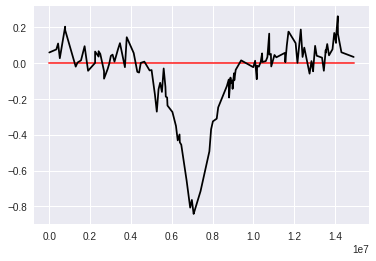

In [14]:
uniform_time = np.linspace(times.min(), times.max(), 1000)
for k, v in candidates.items():
    temp = microlens(tE=pars['tE'][k], U0=pars['U0'][k], fs=pars['fs'][k], t0=(t0 - times_match[k])%times.duration)
    temp = temp.eval(uniform_time)
    plt.plot(uniform_time, temp, 'r', alpha=0.5)
    
plt.plot(times, data, 'k')

IndexError: index out of range

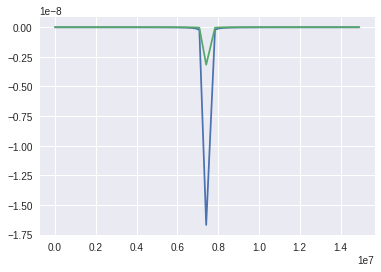

In [10]:
uniform_time = np.linspace(times.min(), times.max(), 1000)
rms = []

def RMS(data, temp):
    N = len(data)
    err = 0
    for i in range(N):
        err += (data[i] - temp[i])**2
    return err
    
for k, v in candidates.items():
    temp = microlens(tE=pars['tE'][k], U0=pars['U0'][k], fs=pars['fs'][k], t0=(t0 - times_match[k])%times.duration)
    temp = temp.eval(times)
    err = RMS(data, temp)
    heappush(rms, (err, k))

for i in range(5):
    err, idx = heappop(rms)
    final_temp = microlens(tE=pars['tE'][idx], 
                           U0=pars['U0'][idx], 
                           fs=pars['fs'][idx], 
                           t0=(t0 - times_match[idx])%times.duration)
    final_temp = final_temp.eval(times)
    plt.plot(times, final_temp)
plt.plot(times, data)

In [ ]:
x = np.linspace()